<a href="https://colab.research.google.com/github/ImGAMP/Improving-Deep-Neural-Networks/blob/main/Deep_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Importar libreria OpenCV y TensorFlow

In [1]:
%tensorflow_version 1.x
import cv2 as cv
import requests
import os
import numpy as np
import math
import h5py
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import tensorflow as tf
from PIL import Image
from tensorflow.python.framework import ops
from skimage.transform import resize
%matplotlib inline
np.random.seed(1)


TensorFlow 1.x selected.


In [2]:
from google.colab import drive
drive.mount('/content/gdrive')
data_path= 'gdrive/My Drive/Sistemas Inteligentes/dataSet'
proof_path = 'gdrive/My Drive/Sistemas Inteligentes/pruebaSet'

Mounted at /content/gdrive


In [3]:

faceArr,  typeArr = [], []
imagePath = [os.path.join(data_path,f) for f in os.listdir(data_path)]
for paths in imagePath:
  if os.path.split(paths)[-1].split('.')[-1] != 'jpg':
    print("", end = "")
  img = Image.open(paths).convert('L')
  img = img.resize((int(128),int(128)))
  imgArr = np.array(img,'uint8')
  pr = [int(os.path.split(paths)[-1].split('.')[1])]
  if imgArr.size != 0:
    faceArr.append(imgArr)
    typeArr.append(pr)

proofArr, typeProof = [], []
imagePath = [os.path.join(proof_path,f) for f in os.listdir(proof_path)]
for paths in imagePath:
  if os.path.split(paths)[-1].split('.')[-1] != 'jpg':
    print("",end = "")
  img = Image.open(paths).convert('L')
  img = img.resize((int(128),int(128)))
  imgArr = np.array(img,'uint8')
  faceId = [int(os.path.split(paths)[-1].split('.')[1])]
  if imgArr.size != 0:
    proofArr.append(imgArr)
    typeProof.append(faceId)

Make functions

In [4]:
def random_mini_batches(X,Y, mini_batch_size = 64, seed = 0):
  #initialization
  m = X.shape[1]
  mini_batches= []
  np.random.seed(seed)

  #Step 1
  permutation = list(np.random.permutation(m))
  X_shuffled = X[:,permutation]
  Y_shuffled = Y[:,permutation]
  #Step 2
  num_complete_minibatches = math.floor(m/mini_batch_size)
  for k in range(0, num_complete_minibatches):
    mini_batch_X = X_shuffled[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
    mini_batch_Y = Y_shuffled[:, k * mini_batch_size : k * mini_batch_size + mini_batch_size]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)
  #end case
  if m % mini_batch_size != 0:
    mini_batch_X = X_shuffled[:,num_complete_minibatches * mini_batch_size : m]
    mini_batch_Y = Y_shuffled[:,num_complete_minibatches * mini_batch_size : m]
    mini_batch = (mini_batch_X, mini_batch_Y)
    mini_batches.append(mini_batch)

  return mini_batches

def convert_to_one_hot(Y,C):
  Y = np.eye(C)[Y.reshape(-1)].T
  return Y

# Graded function 
def linear_function():
  np.random.seed(1) 
  # Create shape X,W,b,Y
  X = tf.constant(np.random.randn(3,1),name="X")
  W = tf.constant(np.random.randn(4,3),name="W")
  b = tf.constant(np.random.randn(4,1),name="b")
  Y = tf.add(tf.matmul(W,X),b)
  #Create session
  sess = tf.Session()
  result = sess.run(Y)
  sess.close()

  return result

# Graded function 
def sigmoid(z):
  x = tf.placeholder(tf.float32, name="x")
  sigmoid = tf.sigmoid(x)
  #Create session
  sess = tf.Session()
  result = sess.run(sigmoid, feed_dict={x:z})
  sess.close()
  
  return result

# Graded function 
def cost(logits, labels):
  z = tf.placeholder(tf.float32, name = "z")
  y = tf.placeholder(tf.float32, name = "y")
  # Use the loss function
  cost = tf.nn.sigmoid_cross_entropy_with_logits(logits = z,  labels = y)
  # Create session
  sess = tf.Session()
  cost = sess.run(cost, feed_dict={z: logits, y: labels})
  sess.close()
  
  return cost

# Graded function 
def one_hot_matrix(labels, C):
  # Create a tf.constant equal to C 
  C = tf.constant(C, name="C")  
  # Use tf.one_hot, be careful with the axis (approx. 1 line)
  one_hot_matrix = tf.one_hot(labels, C, axis=0)
  # Create session
  sess = tf.Session()
  one_hot = sess.run(one_hot_matrix)
  sess.close()
    
  return one_hot

# Graded function 
def ones(shape):
  # Create "ones" tensor 
  ones = tf.ones(shape)
  # Create session 
  sess = tf.Session()
  ones = sess.run(ones)
  sess.close()
  
  return ones

Model

In [5]:
#Define the names of the Dataset for the neural network
Train_x = np.array(faceArr)
Train_y = np.array(typeArr)
Test_x = np.array(proofArr)
Test_y = np.array(typeProof)

In [6]:
print(Train_x.shape)
print(Test_x.shape)
unique, counts = np.unique(Train_y, return_counts=True)
uniques, count = np.unique(Test_y, return_counts=True)
print(dict(zip(unique, counts/1558)))
print(dict(zip(uniques, count/141)))

(1558, 128, 128)
(141, 128, 128)
{0: 0.38254172015404364, 1: 0.6174582798459564}
{0: 0.3971631205673759, 1: 0.6028368794326241}


In [7]:
#Flattern images
X_train_flatten = Train_x.reshape(Train_x.shape[0], -1).T
X_test_flatten = Test_x.reshape(Test_x.shape[0], -1).T
# Normalize image vectors
X_train = X_train_flatten/255.
X_test = X_test_flatten/255.
#Convert one hot matrices Y
Y_train = convert_to_one_hot(Train_y,6)
Y_test = convert_to_one_hot(Test_y,6)

In [8]:
#Knowing data
print("Number of training examples = "+str(X_train.shape[1]))
print("Number of test examples = "+str(X_test.shape[1]))
print("Shape X training = "+str(X_train.shape))
print("Shape Y training = "+str(Y_train.shape))
print("Shape X test = "+str(X_test.shape))
print("Shape Y test = "+str(Y_test.shape))

Number of training examples = 1558
Number of test examples = 141
Shape X training = (16384, 1558)
Shape Y training = (6, 1558)
Shape X test = (16384, 141)
Shape Y test = (6, 141)


y = 1


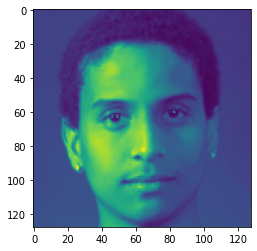

In [9]:
#Example of image
index = 0
#print(X_test.shape)
plt.imshow(Train_x[index])
print ("y = " + str(np.squeeze(Train_y[index])))

Model Functions

In [10]:
#Graded function
def create_placeholders(n_x, n_y):
  #For the tensorflow session
  X = tf.placeholder("float", [n_x, None])
  Y = tf.placeholder("float", [n_y, None])
  
  return X, Y
#Initializing function
def initialize_parameters():
  tf.set_random_seed(1)                              
  
  W1 = tf.get_variable("W1", [25,16384], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
  b1 = tf.get_variable("b1", [25,1], initializer = tf.zeros_initializer())
  W2 = tf.get_variable("W2", [12,25], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
  b2 = tf.get_variable("b2", [12,1], initializer = tf.zeros_initializer())
  W3 = tf.get_variable("W3", [6,12], initializer = tf.contrib.layers.xavier_initializer(seed = 1))
  b3 = tf.get_variable("b3", [6,1], initializer = tf.zeros_initializer())
  
  parameters = {"W1": W1,
                  "b1": b1,
                  "W2": W2,
                  "b2": b2,
                  "W3": W3,
                  "b3": b3}
    
  return parameters

#Graded function
def forward_propagation(X, parameters):

 # Retrieve the parameters from the dictionary "parameters" 
 W1 = parameters['W1']
 b1 = parameters['b1']
 W2 = parameters['W2']
 b2 = parameters['b2']
 W3 = parameters['W3']
 b3 = parameters['b3']
 #Operations 
 Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
 A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
 Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
 A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
 Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
 
 return Z3

#Graded function
def compute_cost(z3, Y):
  logits = tf.transpose(z3)
  labels = tf.transpose(Y)
  #TensorFlow function
  cost = tf.reduce_mean(tf.nn.softmax_cross_entropy_with_logits(logits = logits, labels = labels))
  
  return cost
   

In [11]:
#Model : LINEAR -> RELU -> LINEAR -> RELU -> LINEAR -> SOFTMAX
def model(X_train, Y_train, X_test, Y_test, learning_rate = 0.0001,
          num_epochs = 1500, minibatch_size = 32, print_cost = True):
  #Initial parameters
  ops.reset_default_graph()                         # to be able to rerun the model without overwriting tf variables
  tf.set_random_seed(1)                             # to keep consistent results
  seed = 3                                          # to keep consistent results
  (n_x, m) = X_train.shape                          # (n_x: input size, m : number of examples in the train set)
  n_y = Y_train.shape[0]                                  # n_y : output size
  costs = []                                        # To keep track of the cost
  X, Y = create_placeholders(n_x, n_y)
  
  # Initialize parameters
  parameters = initialize_parameters()
  # Forward propagation: Build the forward propagation in the tensorflow graph
  z3 = forward_propagation(X, parameters)
  # Cost function: Add cost function to tensorflow graph
  cost = compute_cost(z3, Y)
  # Backpropagation: Define the tensorflow optimizer. Use an AdamOptimizer.
  optimizer = tf.train.AdamOptimizer(learning_rate = learning_rate).minimize(cost)
  # Initialize all the variables
  init = tf.global_variables_initializer()
  # Start the session to compute the tensorflow graph
  with tf.Session() as sess:
    sess.run(init)
    for epoch in range(num_epochs):
      minibatch_cost = 0.
      num_minibatches = int(m / minibatch_size) # number of minibatches of size minibatch_size in the train set
      seed = seed + 1
      minibatches = random_mini_batches(X_train, Y_train, minibatch_size, seed)
      for minibatch in minibatches:
        # Select a minibatch
        (minibatch_X, minibatch_Y) = minibatch
        _ , temp_cost = sess.run([optimizer, cost], feed_dict={X: minibatch_X, Y: minibatch_Y})
        minibatch_cost += temp_cost / num_minibatches

      if print_cost == True and epoch % 100 == 0:
        print ("Cost after epoch %i: %f" % (epoch, minibatch_cost))
      if print_cost == True and epoch % 5 == 0:
        costs.append(minibatch_cost)
    # plot the cost
    plt.plot(np.squeeze(costs))
    plt.ylabel('cost')
    plt.xlabel('iterations (per tens)')
    plt.title("Learning rate =" + str(learning_rate))
    plt.show()
    # lets save the parameters in a variable
    parameters = sess.run(parameters)
    print ("Parameters have been trained!")
    # Calculate the correct predictions
    correct_prediction = tf.equal(tf.argmax(z3), tf.argmax(Y))
    # Calculate accuracy on the test set
    accuracy = tf.reduce_mean(tf.cast(correct_prediction, "float"))
    print ("Train Accuracy:", accuracy.eval({X: X_train, Y: Y_train}))
    print ("Test Accuracy:", accuracy.eval({X: X_test, Y: Y_test}))
        
    return parameters


The TensorFlow contrib module will not be included in TensorFlow 2.0.
For more information, please see:
  * https://github.com/tensorflow/community/blob/master/rfcs/20180907-contrib-sunset.md
  * https://github.com/tensorflow/addons
  * https://github.com/tensorflow/io (for I/O related ops)
If you depend on functionality not listed there, please file an issue.

Instructions for updating:

Future major versions of TensorFlow will allow gradients to flow
into the labels input on backprop by default.

See `tf.nn.softmax_cross_entropy_with_logits_v2`.

Cost after epoch 0: 0.657592
Cost after epoch 100: 0.031096
Cost after epoch 200: 0.004267
Cost after epoch 300: 0.000738
Cost after epoch 400: 0.000177
Cost after epoch 500: 0.000543
Cost after epoch 600: 0.000122
Cost after epoch 700: 0.000104
Cost after epoch 800: 0.000037
Cost after epoch 900: 0.000012
Cost after epoch 1000: 0.000001
Cost after epoch 1100: 0.000014
Cost after epoch 1200: 0.000002
Cost after epoch 1300: 0.000001
Cost afte

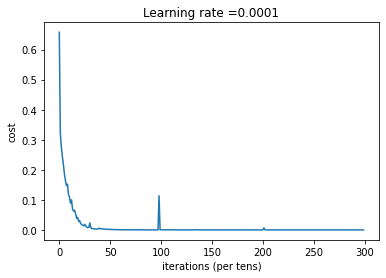

Parameters have been trained!
Train Accuracy: 1.0
Test Accuracy: 0.8652482


In [12]:
#Running model
parameters = model(X_train, Y_train, X_test, Y_test)

In [13]:
def predict(X, parameters):
    
    W1 = tf.convert_to_tensor(parameters["W1"])
    b1 = tf.convert_to_tensor(parameters["b1"])
    W2 = tf.convert_to_tensor(parameters["W2"])
    b2 = tf.convert_to_tensor(parameters["b2"])
    W3 = tf.convert_to_tensor(parameters["W3"])
    b3 = tf.convert_to_tensor(parameters["b3"])
    
    params = {"W1": W1,
              "b1": b1,
              "W2": W2,
              "b2": b2,
              "W3": W3,
              "b3": b3}
    
    x = tf.placeholder("float", [16384, 1])
    
    z3 = forward_propagation_for_predict(x, params)
    p = tf.argmax(z3)
    
    sess = tf.Session()
    prediction = sess.run(p, feed_dict = {x: X})
        
    return prediction

def forward_propagation_for_predict(X, parameters):
    
    # Retrieve the parameters from the dictionary "parameters" 
    W1 = parameters['W1']
    b1 = parameters['b1']
    W2 = parameters['W2']
    b2 = parameters['b2']
    W3 = parameters['W3']
    b3 = parameters['b3'] 
                                                           # Numpy Equivalents:
    Z1 = tf.add(tf.matmul(W1, X), b1)                      # Z1 = np.dot(W1, X) + b1
    A1 = tf.nn.relu(Z1)                                    # A1 = relu(Z1)
    Z2 = tf.add(tf.matmul(W2, A1), b2)                     # Z2 = np.dot(W2, a1) + b2
    A2 = tf.nn.relu(Z2)                                    # A2 = relu(Z2)
    Z3 = tf.add(tf.matmul(W3, A2), b3)                     # Z3 = np.dot(W3,Z2) + b3
    
    return Z3
    

Your algorithm predicts: y = 1


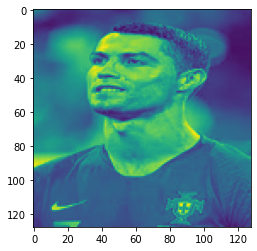

In [14]:
#Proof the model
my_image = Image.open("profesor.jpg").convert('L')
my_image = my_image.resize((128,128))
image = np.array(my_image,'uint8')
image = image/255.
my_image = image.reshape((1,128*128)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))

Your algorithm predicts: y = 0


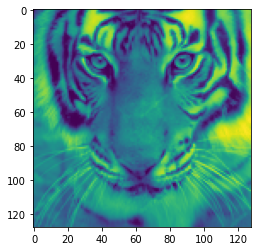

In [23]:
#Proof the model
my_image = Image.open("prueba10.jpg").convert('L')
my_image = my_image.resize((128,128))
image = np.array(my_image,'uint8')
image = image/255.
my_image = image.reshape((1,128*128)).T
my_image_prediction = predict(my_image, parameters)

plt.imshow(image)
print("Your algorithm predicts: y = " + str(np.squeeze(my_image_prediction)))